In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


In [3]:
raw_data = pd.read_csv('../datasets/bars_v1.csv', delimiter = ',')
raw_data.head()

,t,o,h,l,c,v,n,vw,symbol
0,2015-12-01 09:00:00+00:00,118.88,118.94,118.60,118.65,5825,15,118.696799,AAPL
1,2015-12-01 09:00:00+00:00,84.05,84.20,83.50,83.90,15743,49,83.890588,BABA
2,2015-12-01 09:00:00+00:00,668.00,668.49,667.89,667.89,882,10,668.056961,AMZN
3,2015-12-01 09:00:00+00:00,746.00,746.00,746.00,746.00,138,1,746.000000,GOOG
4,2015-12-01 09:00:00+00:00,104.42,104.42,104.42,104.42,200,1,104.420000,META


In [4]:
def process_stock_data(df):
    df['t'] = pd.to_datetime(df['t'])
    df = df.set_index('t')
    df = df.drop(columns=['symbol'])
    return df

In [5]:
stocks_data = {}
for symbol, stock_df in raw_data.groupby('symbol'):
    stocks_data[symbol] = process_stock_data(stock_df)

In [6]:
print(stocks_data['AAPL'].shape)
stocks_data['AAPL'].head()

(29678, 7)


,o,h,l,c,v,n,vw
t,,,,,,,
2015-12-01 09:00:00+00:00,118.88,118.94,118.60,118.65,5825,15,118.696799
2015-12-01 10:00:00+00:00,118.65,118.72,118.50,118.72,7077,24,118.585340
2015-12-01 11:00:00+00:00,118.71,118.99,118.71,118.90,14956,72,118.858641
2015-12-01 12:00:00+00:00,118.88,118.98,118.76,118.94,24677,129,118.857629
2015-12-01 13:00:00+00:00,118.88,119.00,118.60,118.63,95036,309,118.732677


In [7]:
print(f"The avg num of instances per day is {stocks_data['AAPL']['c'].resample('D').count().mean():.2f}")
print(f"The avg num of instances per week is {stocks_data['AAPL']['c'].resample('W').count().mean():.2f}")

The avg num of instances per day is 11.08
The avg num of instances per week is 77.49


In [8]:
def rsi(x):
    delta = x['c'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=14).mean()
    avg_loss = loss.rolling(window=14).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

In [9]:
transformations_v0 = {
    'range': (lambda x: x['h'] - x['l']),
    'avg_price': (lambda x: (x['o'] + x['h'] + x['l'] + x['c']) / 4),
    'price_change': lambda x: x['c'] - x['o'],
    'pct_price_change': lambda x: (x['c'] - x['o']) / x['o'] * 100,
    'log_return': lambda x: np.log(x['vw'] / x['vw'].shift(1)),
    'smaS': lambda x: x['c'].rolling(window=11).mean(),
    'smaM': lambda x: x['c'].rolling(window=33).mean(),
    'smaL': lambda x: x['c'].rolling(window=77).mean(),
    'emaS': lambda x: x['c'].ewm(span=11).mean(),
    'emaM': lambda x: x['c'].ewm(span=33).mean(),
    'emaL': lambda x: x['c'].ewm(span=77).mean(),
    'obv': lambda x: (np.sign(x['c'].diff()) * x['v']).fillna(0).cumsum(),
    'vwap': lambda x: (x['vw'] / x['v']).cumsum(),
    'log_v': lambda x: np.log(x['v']),
    'log_n': lambda x: np.log(x['n']),
    'log_vw': lambda x: np.log(x['vw']),
    'log_avg_price': lambda x: np.log(x['avg_price']),
    'scaled_pct_price_change': lambda x: (x['pct_price_change'] - x['pct_price_change'].mean()) / x['pct_price_change'].std(),
    'scaled_log_return': lambda x: (x['log_return'] - x['log_return'].mean()) / x['log_return'].std(),
    'detrended_c': lambda x: x['c'] - x['ema50'],
    'sma_vwap': lambda x: x['vwap'].rolling(window=14).mean(),
    'detrended_vwap': lambda x: x['vwap'] - x['sma_vwap'],
    'standardized_obv': lambda x: (x['obv'] - x['obv'].mean()) / x['obv'].std(),
    'rsi': lambda x: rsi(x)
}

In [10]:
# ( ) o  -> x['o']
# ( ) h  -> x['h']
# ( ) c  -> x['c']
# ( ) l  -> x['l']
# ( ) v  -> x['v']
# ( ) vw -> x['vw']
# ( ) n  -> x['n']
# ---
# ( ) diff -> x['vw'] / x['vw'].shift(1)
# ( ) s    -> x['diff'].ewm(span=77).std()
# (x) emaS -> x['diff'].ewm(span=11).mean()
# (x) emaM -> x['diff'].ewm(span=33).mean()
# (x) emaL -> x['diff'].ewm(span=77).mean()
# (x) std  -> np.log(x['s'])
# (x) pc   -> (x['diff'] - x['emaL']) / x['s']
# ---
# (x) mvS -> np.log(x['v']).ewm(span=11).mean()
# (x) mvL -> np.log(x['v']).ewm(span=77).mean()
# (x) mnS -> np.log(x['n']).ewm(span=11).mean()
# (x) mnL -> np.log(x['n']).ewm(span=77).mean()
# ---
# (x) rsi  -> rsi(x)
# (x) rsid -> x['rsi'] - x['rsi'].ewm(span=11).mean()
# ---
# (x) rlmS -> np.log(x['h'] - x['l']).ewm(span=11).mean()
# (x) rlmL -> np.log(x['h'] - x['l']).ewm(span=77).mean()
# (x) rlmD -> x['rlmS'] - x['rlmL']
# ---
# ( ) obv   -> (np.sign(x['c'].diff()) * x['v']).cumsum()
# ( ) obvmS -> dff['obv'].ewm(span=11).mean()
# ( ) obvmL -> dff['obv'].ewm(span=77).mean()
# ( ) obvsL -> dff['obv'].ewm(span=77).std()
# (x) obvSH -> (x['obvmS'] - x['obvmL']) / x['obvsL']
# ---
# ( ) lavgv -> np.log(dff['v'] / dff['n']).ewm(span=11).mean()
# ( ) lavm  -> x['lavgv'].ewm(span=77).mean()
# ( ) lavs  -> x['lavgv'].ewm(span=77).std()
# (x) avgv  -> (x['lavgv'] - x['lavm']) / x['lavs']
# ---
# ( ) ewm_12   -> x['c'].ewm(span=12).mean()
# ( ) ewm_26   -> x['c'].ewm(span=26).mean()
# ( ) macd     -> x['ewm_12'] - x['ewm_26']
# ( ) signal   -> x['macd'].ewm(span=9).mean()
# ( ) macd_std -> x['macd'].ewm(span=77).std()
# (x) macds    -> (x['macd'] - x['signal']) / x['macd_std']

In [11]:
s_size = 11
m_size = 77
l_size = 333

def _(x):
    return sum(x)

lambda x, y: sum(x) * y

transformations = {
    'diff': lambda x: x['vw'] / x['vw'].shift(1),
    's': lambda x: x['diff'].ewm(span=l_size).std(),
    'emaS': lambda x: x['diff'].ewm(span=s_size).mean(),
    'emaM': lambda x: x['diff'].ewm(span=m_size).mean(),
    'emaL': lambda x: x['diff'].ewm(span=l_size).mean(),
    'std': lambda x: np.log(x['s']),
    'pc': lambda x: (x['diff'] - x['emaL']) / x['s'],
    'mvS': lambda x: np.log(x['v']).ewm(span=s_size).mean(),
    'mvL': lambda x: np.log(x['v']).ewm(span=l_size).mean(),
    'mnS': lambda x: np.log(x['n']).ewm(span=s_size).mean(),
    'mnL': lambda x: np.log(x['n']).ewm(span=l_size).mean(),
    'rsi': lambda x: rsi(x),
    'rsid': lambda x: x['rsi'] - x['rsi'].ewm(span=s_size).mean(),
    'rlmS': lambda x: np.log(x['h'] - x['l']).ewm(span=s_size).mean(),
    'rlmL': lambda x: np.log(x['h'] - x['l']).ewm(span=l_size).mean(),
    'rlmD': lambda x: x['rlmS'] - x['rlmL'],
    'obv': lambda x: (np.sign(x['c'].diff()) * x['v']).cumsum(),
    'obvmS': lambda x: x['obv'].ewm(span=s_size).mean(),
    'obvmL': lambda x: x['obv'].ewm(span=l_size).mean(),
    'obvsL': lambda x: x['obv'].ewm(span=l_size).std(),
    'obvSH': lambda x: (x['obvmS'] - x['obvmL']) / x['obvsL'],
    'lavgv': lambda x: np.log(x['v'] / x['n']).ewm(span=s_size).mean(),
    'lavm': lambda x: x['lavgv'].ewm(span=l_size).mean(),
    'lavs': lambda x: x['lavgv'].ewm(span=l_size).std(),
    'avgv': lambda x: (x['lavgv'] - x['lavm']) / x['lavs'],
    'ewm_12': lambda x: x['c'].ewm(span=12).mean(),
    'ewm_26': lambda x: x['c'].ewm(span=26).mean(),
    'macd': lambda x: x['ewm_12'] - x['ewm_26'],
    'signal': lambda x: x['macd'].ewm(span=9).mean(),
    'macd_std': lambda x: x['macd'].ewm(span=l_size).std(),
    'macds': lambda x: (x['macd'] - x['signal']) / x['macd_std'],
}

to_delete = [
    'o', 'h', 'c', 'l', 'v', 'vw', 'n', 'diff', 's', 'obv', 'obvmS', 'obvmL',
    'obvsL', 'lavgv', 'lavm', 'lavs', 'ewm_12', 'ewm_26', 'macd', 'signal', 'macd_std'
]

In [12]:
def add_metric(df, metric_id):
    if metric_id in transformations:
        df[metric_id] = transformations[metric_id](df)
        return df
    else:
        raise ValueError(f"Unknown metric identifier: {metric_id}")
    

In [13]:
def transform_dataset(df, transformations):
    for metric in transformations.keys():
        add_metric(df, metric)

    return df.drop(columns=to_delete)

In [14]:
df_aapl = transform_dataset(stocks_data['AAPL'].copy(), transformations)
df_aapl.head()

/Users/miquelsaula/mambaforge/envs/TradingStrategies2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/miquelsaula/mambaforge/envs/TradingStrategies2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,emaS,emaM,emaL,std,pc,mvS,mvL,mnS,mnL,rsi,rsid,rlmS,rlmL,rlmD,obvSH,avgv,macds
t,,,,,,,,,,,,,,,,,
2015-12-01 09:00:00+00:00,NaN,NaN,NaN,NaN,NaN,8.669914,8.669914,2.708050,2.708050,NaN,NaN,-1.078810,-1.078810,0.000000,NaN,NaN,NaN
2015-12-01 10:00:00+00:00,0.999061,0.999061,0.999061,NaN,NaN,8.776109,8.767552,2.964416,2.943758,NaN,NaN,-1.316256,-1.297122,-0.019134,NaN,-0.704983,0.628539
2015-12-01 11:00:00+00:00,1.000830,1.000704,1.000688,-6.077614,0.704983,9.107135,9.051018,3.483548,3.390732,NaN,NaN,-1.299130,-1.289022,-0.010108,0.062159,-1.030991,0.988425
2015-12-01 12:00:00+00:00,1.000498,1.000460,1.000454,-6.395711,-0.277310,9.431132,9.319068,3.926578,3.761317,NaN,NaN,-1.368339,-1.345806,-0.022533,0.116553,-1.087482,0.978573
2015-12-01 13:00:00+00:00,1.000000,1.000068,1.000074,-6.465700,-0.723524,9.997036,9.752820,4.430032,4.160474,NaN,NaN,-1.242376,-1.258868,0.016492,-0.087862,-0.665582,-0.725128


In [15]:
df_msft = transform_dataset(stocks_data['MSFT'].copy(), transformations)
df_msft.head()

/Users/miquelsaula/mambaforge/envs/TradingStrategies2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/miquelsaula/mambaforge/envs/TradingStrategies2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,emaS,emaM,emaL,std,pc,mvS,mvL,mnS,mnL,rsi,rsid,rlmS,rlmL,rlmD,obvSH,avgv,macds
t,,,,,,,,,,,,,,,,,
2015-12-01 10:00:00+00:00,NaN,NaN,NaN,NaN,NaN,7.783224,7.783224,0.693147,0.693147,NaN,NaN,-2.813411,-2.813411,0.000000,NaN,NaN,NaN
2015-12-01 11:00:00+00:00,1.001630,1.001630,1.001630,NaN,NaN,7.886447,7.878129,1.292390,1.244103,NaN,NaN,-3.790734,-3.711981,-0.078753,NaN,-0.704983,0.628539
2015-12-01 12:00:00+00:00,1.000116,1.000224,1.000238,-6.233249,-0.704983,7.695458,7.719025,1.650347,1.563720,NaN,NaN,-3.202016,-3.239358,0.037342,-0.062159,-1.012346,-0.640790
2015-12-01 13:00:00+00:00,1.000545,1.000558,1.000561,-6.506626,0.428222,8.565682,8.395015,2.670773,2.385210,NaN,NaN,-2.946399,-3.029628,0.083230,0.101772,-0.931056,0.776187
2015-12-01 14:00:00+00:00,0.999657,0.999838,0.999861,-6.293070,-1.122112,10.445236,9.794857,4.732087,3.940337,NaN,NaN,-2.417918,-2.628897,0.210979,-0.138308,-0.974634,0.435404


<AxesSubplot:xlabel='t'>

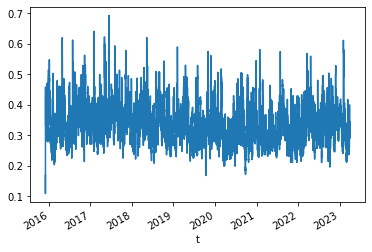

In [18]:
df_aapl['rlmS'].ewm(span=50).std().plot()

In [17]:
import seaborn as sns
def plot_corrmatrix(df):
    corr_matrix = df.corr()

    # Set up a Seaborn theme
    sns.set_theme(style="white")

    # Create a correlation matrix plot
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Create a mask to display only the lower triangle
    cmap = sns.diverging_palette(230, 20, as_cmap=True)  # Generate a custom diverging colormap
    sns.heatmap(corr_matrix, mask=mask, cmap=cmap, center=0, annot=True, fmt=".2f",
                square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot_kws={"fontsize": 10})
    plt.title("Correlation Matrix")
    plt.show()


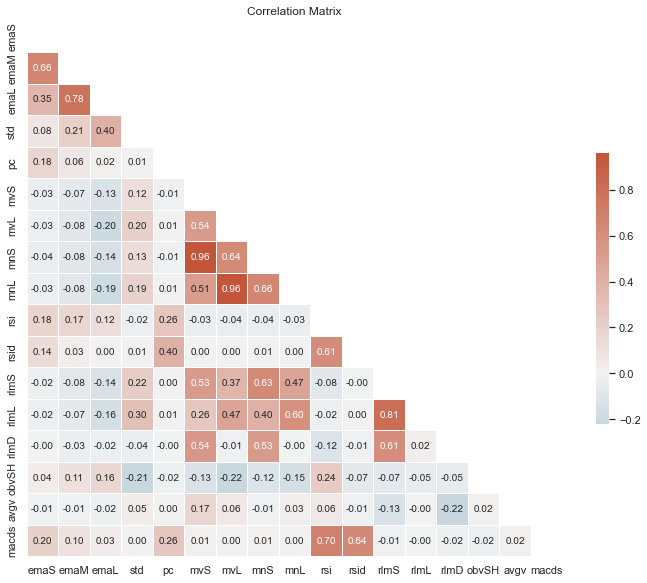

In [18]:
plot_corrmatrix(df_aapl)

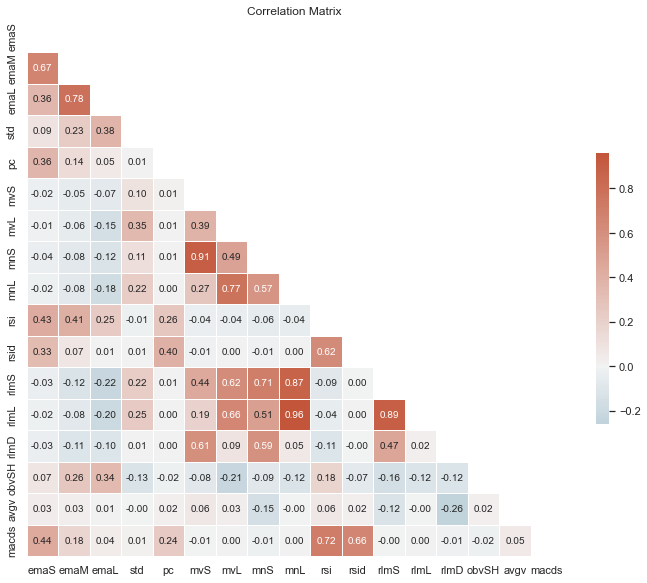

In [19]:
plot_corrmatrix(df_msft)

In [22]:
for df in stocks_data.values():
    df = transform_dataset(df, transformations)

/Users/miquelsaula/mambaforge/envs/TradingStrategies2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/miquelsaula/mambaforge/envs/TradingStrategies2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/miquelsaula/mambaforge/envs/TradingStrategies2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/miquelsaula/mambaforge/envs/TradingStrategies2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/miquelsaula/mambaforge/envs/TradingStrategies2/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by ze

In [29]:
combined_df = pd.concat(stocks_data.values(), keys=stocks_data.keys(), names=['symbol']).reset_index()

In [31]:
combined_df.to_csv('bars_final.csv')
combined_df.head()

,symbol,t,o,h,l,c,v,n,vw,diff,...,lavgv,lavm,lavs,avgv,ewm_12,ewm_26,macd,signal,macd_std,macds
0,AAPL,2015-12-01 09:00:00+00:00,118.88,118.94,118.60,118.65,5825,15,118.696799,NaN,...,5.961864,5.961864,NaN,NaN,118.650000,118.650000,0.000000,0.000000,NaN,NaN
1,AAPL,2015-12-01 10:00:00+00:00,118.65,118.72,118.50,118.72,7077,24,118.585340,0.999061,...,5.811694,5.886553,0.106187,-0.704983,118.687917,118.686346,0.001571,0.000873,0.001111,0.628539
2,AAPL,2015-12-01 11:00:00+00:00,118.71,118.99,118.71,118.90,14956,72,118.858641,1.002305,...,5.623587,5.798371,0.169530,-1.030991,118.770693,118.763110,0.007583,0.003623,0.004007,0.988425
3,AAPL,2015-12-01 12:00:00+00:00,118.88,118.98,118.76,118.94,24677,129,118.857629,0.999991,...,5.504554,5.724254,0.202026,-1.087482,118.824136,118.812561,0.011576,0.006317,0.005374,0.978573
4,AAPL,2015-12-01 13:00:00+00:00,118.88,119.00,118.60,118.63,95036,309,118.732677,0.998949,...,5.567004,5.692425,0.188438,-0.665582,118.771390,118.770224,0.001166,0.004785,0.004990,-0.725128
